In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler

def scaled_trainer(arr, lb, lf, choice):
    sc = MinMaxScaler(feature_range=(-1,1))
    tx = np.array([])
    ty = np.array([])
    t = np.array([])
    tx_new = np.array([])

    for i in arr:
        data = pd.read_csv(i).filter([choice]).values
        data = sc.fit_transform(data)
        t = np.append(t, sliding_window_view(data, window_shape = (lb+lf,1)))

    t = t.reshape(int(t.shape[0]/(lb+lf)), lb+lf)
    for j in t:
        tx = np.append(tx, j[:lb])
        ty = np.append(ty, j[lb:])
    tx = tx.reshape((int(tx.shape[0]/lb), lb))
       
    tx_new = tx_new.reshape((int(tx_new.shape[0]/(lb-1)), (lb-1)))
    ty = ty.reshape((int(ty.shape[0]/lf), lf))

    return tx, ty

[   3 1122  159]


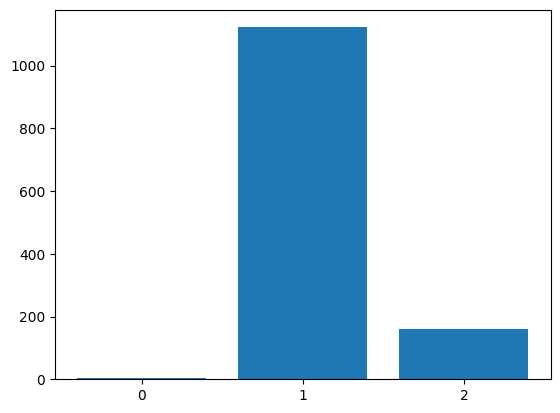

Saved data on asian paints: Input/Output (1284, 200, 200, 5) (1284,)
[ 114 1096   74]


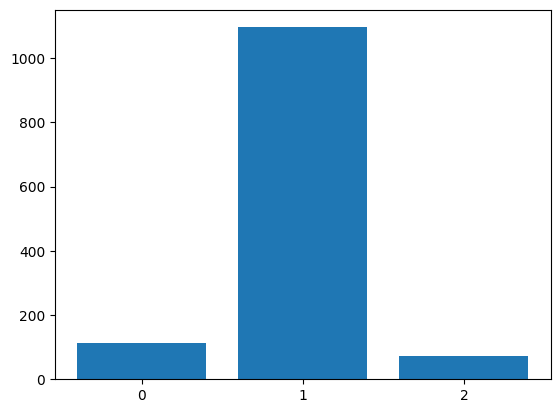

Saved data on edelweiss: Input/Output (1284, 200, 200, 5) (1284,)
[1280    0    4]


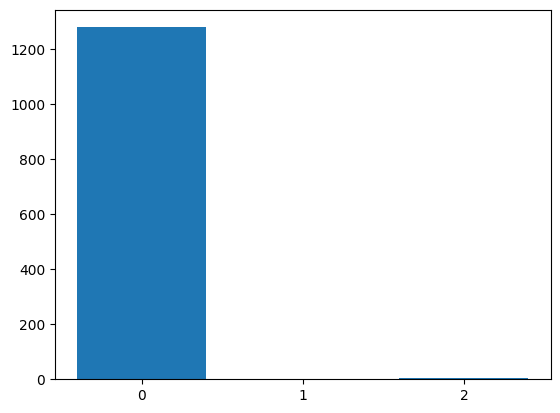

Saved data on infosys: Input/Output (1284, 200, 200, 5) (1284,)
[1281    1    2]


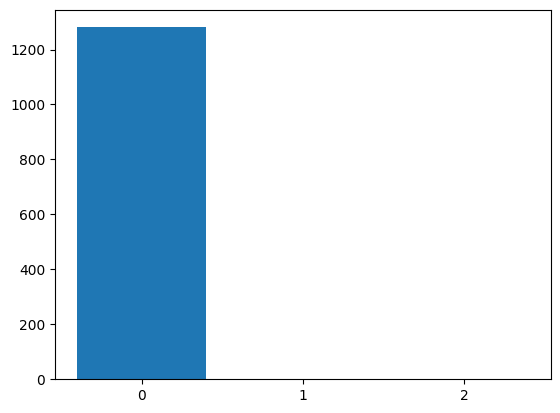

Saved data on reliance industries: Input/Output (1284, 200, 200, 5) (1284,)
[   5 1268   11]


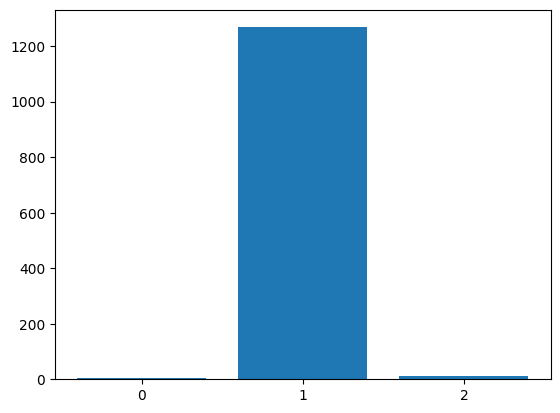

Saved data on reliance power: Input/Output (1284, 200, 200, 5) (1284,)
[1282    0    2]


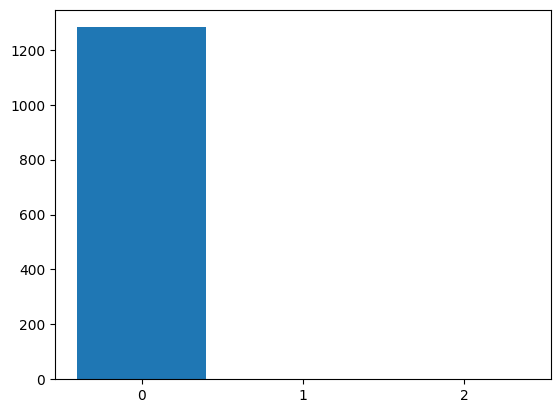

Saved data on tata chemicals: Input/Output (1284, 200, 200, 5) (1284,)


In [ ]:
lb=200
lf=3
#List of companies to train on:
companies = ["asian paints.csv", "edelweiss.csv", "infosys.csv", "reliance industries.csv", 
             "reliance power.csv", "tata chemicals.csv", "tata coffee.csv", 
             "tata motors.csv", "tata steel.csv"]

for com in companies:
    trade_x, _ = scaled_trainer([com], lb, lf, "No. of Trades")
    shl_x, _ = scaled_trainer([com], lb, lf, "Spread High-Low")
    wap_x, wap_y = scaled_trainer([com], lb, lf, "WAP")
    open_x, _y = scaled_trainer([com], lb, lf, "Open Price")
    sco_x, _ = scaled_trainer([com], lb, lf, "Spread Close-Open")
    
    wap_img = np.array([])
    shl_img = np.array([])
    trade_img = np.array([])
    sco_img = np.array([])
    open_img = np.array([])
    for i in range(len(wap_x)):
        eps = 0.1
        d1 = np.abs(np.subtract.outer(wap_x[i],wap_x[i]))
        R1 = np.exp(-d1**2/eps)
        wap_img = np.append(wap_img, [R1])
        d2 = np.abs(np.subtract.outer(shl_x[i],shl_x[i]))
        R2 = np.exp(-d2**2/eps)
        shl_img = np.append(shl_img, [R2])
        d3 = np.abs(np.subtract.outer(trade_x[i],trade_x[i]))
        R3 = np.exp(-d3**2/eps)
        trade_img = np.append(trade_img, [R3]) 
        d4 = np.abs(np.subtract.outer(sco_x[i],sco_x[i]))
        R4 = np.exp(-d3**2/eps)
        sco_img = np.append(sco_img, [R4]) 
        d5 = np.abs(np.subtract.outer(open_x[i],open_x[i]))
        R5 = np.exp(-d3**2/eps)
        open_img = np.append(open_img, [R5]) 
        
    wap_img = wap_img.reshape((int(wap_img.shape[0]/(lb*lb)), lb, lb, 1))
    shl_img = shl_img.reshape((int(shl_img.shape[0]/(lb*lb)), lb, lb, 1))
    trade_img = trade_img.reshape((int(trade_img.shape[0]/(lb*lb)), lb, lb, 1))
    sco_img = sco_img.reshape((int(sco_img.shape[0]/(lb*lb)), lb, lb, 1))
    open_img = open_img.reshape((int(open_img.shape[0]/(lb*lb)), lb, lb, 1))

    x = [1,2,3]
    slopes = np.array([])
    for i in wap_y:
        slope, _ = np.polyfit(x, i, 1)
        slopes = np.append(slopes, slope)

    model_out = np.array([])
    for i in slopes:
        if i<(-0.01):
            model_out = np.append(model_out, 0)
        elif i<=(0.01):
            model_out = np.append(model_out, 1)
        else:
            model_out = np.append(model_out, 2)
    
    bins = np.arange(0, 4)
    hist, _ = np.histogram(slopes, bins=3)
    print(hist)
    plt.bar(bins[:-1], hist, align='center')
    plt.xticks(bins[:-1])
    plt.show()

    model_in = wap_img
    model_in = np.append(model_in, open_img, axis=3)
    model_in = np.append(model_in, shl_img, axis=3)
    model_in = np.append(model_in, sco_img, axis=3)
    model_in = np.append(model_in, trade_img, axis=3)

    np.save(f"input {com[:-4]}", model_in)
    np.save(f"output {com[:-4]}", model_out)
    print(f"Saved data on {com[:-4]}: Input/Output", model_in.shape, model_out.shape)

In [ ]:
lb=200
lf=5
#List of companies to train on:
companies = ["asian paints.csv", "edelweiss.csv", "infosys.csv", "reliance industries.csv", 
             "reliance power.csv", "tata chemicals.csv", "tata coffee.csv", 
             "tata motors.csv", "tata steel.csv"]

In [ ]:
from tensorflow.python.layers import base
import tensorflow as tf
from tensorflow import keras
from keras import layers

class AddCoords(base.Layer):
    """Add coords to a tensor"""
    def __init__(self, x_dim=lb, y_dim=lb, with_r=False):
        super(AddCoords, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r
    def call(self, input_tensor):
        """
        input_tensor: (batch, x_dim, y_dim, c)
        """
        batch_size_tensor = tf.shape(input_tensor)[0]
        xx_ones = tf.ones([batch_size_tensor, self.x_dim], dtype=tf.int32)
        xx_ones = tf.expand_dims(xx_ones, -1)
        xx_range = tf.tile(tf.expand_dims(tf.range(self.y_dim), 0), [batch_size_tensor, 1])
        xx_range = tf.expand_dims(xx_range, 1)
        xx_channel = tf.matmul(xx_ones, xx_range)
        xx_channel = tf.expand_dims(xx_channel, -1)
        yy_ones = tf.ones([batch_size_tensor, self.y_dim], dtype=tf.int32)
        yy_ones = tf.expand_dims(yy_ones, 1)
        yy_range = tf.tile(tf.expand_dims(tf.range(self.x_dim), 0), [batch_size_tensor, 1])
        yy_range = tf.expand_dims(yy_range, -1)
        yy_channel = tf.matmul(yy_range, yy_ones)
        yy_channel = tf.expand_dims(yy_channel, -1)
        xx_channel = tf.cast(xx_channel, 'float32') / (self.x_dim - 1)
        yy_channel = tf.cast(yy_channel, 'float32') / (self.y_dim - 1)
        xx_channel = xx_channel*2 - 1
        yy_channel = yy_channel*2 - 1
        ret = tf.concat([input_tensor, xx_channel, yy_channel], axis=-1)
        if self.with_r:
            rr = tf.sqrt( tf.square(xx_channel) + tf.square(yy_channel))
            ret = tf.concat([ret, rr], axis=-1)
        return ret

class CoordConv(base.Layer):
    """CoordConv layer as in the paper."""
    def __init__(self, x_dim, y_dim, with_r, *args, **kwargs):
        super(CoordConv, self).__init__()
        self.addcoords = AddCoords(x_dim=x_dim,
        y_dim=y_dim,
        with_r=with_r)
        self.conv = layers.Conv2D(*args, **kwargs)
    def call(self, input_tensor):
        ret = self.addcoords(input_tensor)
        ret = self.conv(ret)
        return ret    

In [ ]:
def inception_module(inputs, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
    # 1x1 conv layer
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(inputs)

    # 3x3 conv layer
    conv_3x3_reduce = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3_reduce)

    # 5x5 conv layer
    conv_5x5_reduce = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5_reduce)

    # Max pooling layer
    max_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    max_pool_conv = tf.keras.layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(max_pool)

    # Concatenate the outputs of all conv layers
    outputs = tf.keras.layers.Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, max_pool_conv])

    return outputs


In [ ]:
# addlayer = AddCoords()

# input1 = keras.Input(shape=(lb,lb,1), name="wap")
# input2 = keras.Input(shape=(lb,lb,1), name="open")
# input3 = keras.Input(shape=(lb,lb,1), name="shl")
# input4 = keras.Input(shape=(lb,lb,1), name="sco")
# input5 = keras.Input(shape=(lb,lb,1), name="trades")
# inputs = layers.Concatenate(axis=-1)([input1, input2, input3, input4, input5])
# inputs = addlayer(inputs)
# x = layers.Conv2D(32, 3, activation='relu', input_shape=(lb,lb,7))(inputs)
# x = layers.Conv2D(64, 3, activation='relu')(x)
# x = layers.Conv2D(64, 3, activation='relu')(x)
# x = layers.AveragePooling2D((2,2))(x)
# x = layers.Conv2D(128, 5, activation='relu')(x)
# x = layers.Conv2D(128, 10, activation='relu')(x)
# x = layers.AveragePooling2D((2,2))(x)
# x = layers.Conv2D(256, 15, activation='relu')(x)
# x = layers.Conv2D(256, 15, activation='relu')(x)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(64, activation='tanh')(x)
# x = layers.Dense(32, activation='tanh')(x)
# x = layers.Dense(16, activation='tanh')(x)
# output = layers.Dense(3, activation='softmax')(x)

# seer = keras.Model([input1, input2, input3, input4, input5], output, name='seer')
# seer.summary()

In [ ]:
addcoords = AddCoords()
input1 = keras.Input(shape=(lb,lb,1), name="wap")
input2 = keras.Input(shape=(lb,lb,1), name="open")
input3 = keras.Input(shape=(lb,lb,1), name="shl")
input4 = keras.Input(shape=(lb,lb,1), name="sco")
input5 = keras.Input(shape=(lb,lb,1), name="trades")
inputs = layers.Concatenate(axis=-1)([input1, input2, input3, input4, input5])
inputs = addcoords(inputs)
x = layers.Conv2D(64, 10, padding='same', activation='relu')(inputs)
x = layers.Conv2D(64, 10, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 10, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 128, 112, 64, 64, 32, 32)
x = inception_module(x, 256, 200, 128, 128, 112, 112)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='tanh')(x)
output = layers.Dense(3, activation='softmax')(x)
seer = keras.Model([input1, input2, input3, input4, input5], output, name='seer')
seer.summary()

In [ ]:
base_learning_rate = 1e-4
seer.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
import os
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


In [ ]:
history = []
#Uncomment the line below when using pre-trained weights 
#model.load_weights(checkpoint_path)

for com in companies:
    model_in = np.load(f"input {com[:-4]}.npy")
    wap = model_in[:,:,:,0].reshape((-1, lb, lb, 1))
    open = model_in[:,:,:,1].reshape((-1, lb, lb, 1))
    shl = model_in[:,:,:,2].reshape((-1, lb, lb, 1))
    sco = model_in[:,:,:,3].reshape((-1, lb, lb, 1))
    trades = model_in[:,:,:,4].reshape((-1, lb, lb, 1))
    model_out = np.load(f"output {com[:-4]}.npy")

    print(f"Training on {com[:-4]} data")

    history.append(seer.fit([wap, open, shl, sco, trades], model_out, epochs=25, validation_split=0.2, verbose=2, 
                        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-5),
                        keras.callbacks.ReduceLROnPlateau(monitor="val_loss",min_delta=0.0005, factor=0.5, patience=3, min_lr=1e-6),
                        keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)]))
    


In [ ]:
for i in range(len(companies)):
    acc = history[i].history['accuracy']
    val_acc = history[i].history['val_accuracy']

    loss = history[i].history['loss']
    val_loss = history[i].history['val_loss']

    plt.figure(figsize=(5, 5))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
seer([wap[127].reshape((1,lb,lb,1)), open[127].reshape((1,lb,lb,1)), shl[127].reshape((1,lb,lb,1))
            , sco[127].reshape((1,lb,lb,1)), trades[127].reshape((1,lb,lb,1))]), model_out[127]